# 04 — Verify Inference & Compare All Models (v4)

**Models:** XGB, LGB, Ridge, GRU, TCN  
**Baselines:** Persistence, Climatology  
**Targets:** temp, rain, u10, v10, rh, press, cloud  
**Horizons:** 1-100 (BINS: D1=1-24, D2=25-48, D3=49-72, D4=73-100)

## Notebook Structure

| Cell | Nội dung |
|------|----------|
| 1 | Settings & Imports |
| 2 | Helper Functions |
| 3 | Prediction Functions (Ridge, XGB, LGB) |
| 4 | Run All Predictions (Tabular + Sequence) |
| 5 | Baselines & Merge |
| 6 | Summary Tables & Skill Scores |
| 7 | Visualizations |
| 8 | Quality Check |

## Notes
- **Ridge**: `log1p(Y)` cho rain → `expm1()` khi predict
- **XGB/LGB**: rain 2-stage (classifier + regressor với log1p)
- **GRU/TCN**: load metrics từ report files

In [1]:
# ============================================================
# CELL 1: SETTINGS & IMPORTS
# ============================================================
import os, gc, json, joblib
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

# ==================== SETTINGS ====================
PROJECT_ROOT = None  # Override: r"D:\FinalProject\AlterDemo"
MAX_ROWS = None      # Quick test: 2000

LAG, H = 49, 100
H_START, H_END = 1, 100
BINS = ((1, 24), (25, 48), (49, 72), (73, 100))
BIN_NAMES = ["D1 (1-24h)", "D2 (25-48h)", "D3 (49-72h)", "D4 (73-100h)"]

TARGETS = ["temp", "rain", "u10", "v10", "rh", "press", "cloud"]
FAMILIES = ["Ridge", "XGB", "LGB", "GRU", "TCN"]
BASELINES = ["Persistence", "Climatology"]

TARGET_COL_MAP = {
    "temp": "temperature_2m", "rain": "precipitation",
    "u10": "u10", "v10": "v10", "rh": "relative_humidity_2m",
    "press": "surface_pressure", "cloud": "cloud_cover"
}
TARGETS_SEQ_MAP = {v: k for k, v in TARGET_COL_MAP.items()}

RAIN_THR, P_THR = 0.1, 0.5
OUT_DIR = Path("./verify_reports_v4")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ==================== PATH DISCOVERY ====================
def find_project_root():
    if PROJECT_ROOT: return Path(PROJECT_ROOT)
    cwd = Path.cwd()
    candidates = [cwd] + [p for p in cwd.iterdir() if p.is_dir()]
    def score(p):
        s = 0
        for pat in ["weather_20loc", "weather_4loc"]:
            if (p / pat / "data" / "tabular").is_dir(): s += 100
        for d in ["xgb_out_singlekeys", "lgb_out_singlekeys", "ridge_out_singlekeys_fast"]:
            if (p / d).is_dir(): s += 20
        return s
    best = max(candidates, key=score)
    if score(best) <= 0: raise RuntimeError("Cannot find project root")
    return best

ROOT = find_project_root()

# Auto-detect data dir
DATA_ROOT = None
for pat in ["weather_20loc", "weather_4loc"]:
    if (ROOT / pat / "data" / "tabular").is_dir():
        DATA_ROOT = ROOT / pat; break
if DATA_ROOT is None: raise FileNotFoundError("Cannot find weather data directory")

TAB_DIR  = DATA_ROOT / "data" / "tabular"
META_DIR = DATA_ROOT / "data" / "meta"
PROC_DIR = DATA_ROOT / "data" / "processed"

XGB_ROOT   = ROOT / "xgb_out_singlekeys"
LGB_ROOT   = ROOT / "lgb_out_singlekeys"
RIDGE_ROOT = ROOT / "ridge_out_singlekeys_fast"
GRU_ROOT   = ROOT / "gru_weather_v3_out"
TCN_ROOT   = ROOT / "tcn_weather_2step_out"

# ==================== LOAD LOCATIONS ====================
def load_locations():
    with open(META_DIR / "locations.json") as f:
        meta = json.load(f)
    loc_map = {loc["location_id"]: loc["name"] for loc in meta.get("locations", [])}
    return meta.get("location_ids", list(loc_map.keys())), loc_map

LOCATION_IDS, LOC_MAP = load_locations()

# ==================== PRINT INFO ====================
print(f"📁 ROOT: {ROOT}")
print(f"📊 DATA: {DATA_ROOT.name} ({len(LOCATION_IDS)} locations)")
print(f"📍 Locations: {[LOC_MAP.get(lid, lid[:8]) for lid in LOCATION_IDS[:5]]}...")
print()
for name, path in [("XGB", XGB_ROOT), ("LGB", LGB_ROOT), ("Ridge", RIDGE_ROOT), 
                   ("GRU", GRU_ROOT), ("TCN", TCN_ROOT)]:
    status = "✓" if path.is_dir() else "✗"
    print(f"  {name}: {status}")
print(f"\n✅ Cell 1 Done")

📁 ROOT: d:\FinalProject\AlterDemo
📊 DATA: weather_20loc (20 locations)
📍 Locations: ['hanoi', 'haiphong', 'quangninh', 'laocai', 'hagiang']...

  XGB: ✓
  LGB: ✓
  Ridge: ✓
  GRU: ✓
  TCN: ✓

✅ Cell 1 Done


In [2]:
# ============================================================
# CELL 2: HELPER FUNCTIONS
# ============================================================

def ycol(h): 
    return f"y_t+{h:03d}"

def assign_bin(h):
    """Map horizon to bin name"""
    for i, (start, end) in enumerate(BINS):
        if start <= h <= end: return BIN_NAMES[i]
    return "Unknown"

# ==================== METRICS ====================
def mae(yhat, y): 
    return float(np.mean(np.abs(yhat - y)))

def rmse(yhat, y): 
    return float(np.sqrt(np.mean((yhat - y)**2)))

def event_metrics(y_true, y_pred, thr=0.1):
    """Precision, Recall, F1 for rain events"""
    yt = (y_true >= thr).astype(int)
    yp = (y_pred >= thr).astype(int)
    tp = ((yt == 1) & (yp == 1)).sum()
    fp = ((yt == 0) & (yp == 1)).sum()
    fn = ((yt == 1) & (yp == 0)).sum()
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)
    return float(prec), float(rec), float(f1)

# ==================== DATA LOADING ====================
def load_test_xy(loc_id, target):
    """Load test parquet → X, Y"""
    hits = list(TAB_DIR.glob(f"{loc_id}_test_*_tab_{target}_lag{LAG}_h{H}.parquet"))
    if not hits: raise FileNotFoundError(f"No file: {loc_id}/{target}")
    
    cols = pq.ParquetFile(hits[0]).schema.names
    feat_cols = [c for c in cols if "_lag" in c]
    y_cols = [ycol(h) for h in range(H_START, H_END + 1)]
    
    X = pd.read_parquet(hits[0], columns=feat_cols).to_numpy(np.float32)
    Y = pd.read_parquet(hits[0], columns=y_cols).to_numpy(np.float32)
    
    if MAX_ROWS: X, Y = X[:MAX_ROWS], Y[:MAX_ROWS]
    return X, Y

def load_proc_df(loc_id):
    """Load processed hourly data for climatology"""
    path = PROC_DIR / f"{loc_id}_hourly_proc.parquet"
    if not path.exists(): return None
    df = pd.read_parquet(path)
    df["time"] = pd.to_datetime(df["time"], utc=True)
    df["hour"]  = df["time"].dt.hour
    df["month"] = df["time"].dt.month
    return df

print("✅ Cell 2 Done")

✅ Cell 2 Done


In [3]:
# ============================================================
# CELL 3: PREDICTION FUNCTIONS
# ============================================================

def ridge_predict(loc_id, target, X):
    """Ridge multi-output (log1p for rain)"""
    mpath = RIDGE_ROOT / "models" / target / f"ridge_{target}_{loc_id}_multi_h001-100.joblib"
    spath = RIDGE_ROOT / "models" / target / f"scaler_{target}_{loc_id}_lag{LAG}_h{H}.joblib"
    if not spath.exists():
        spath = RIDGE_ROOT / "models" / target / f"scaler_{target}_{loc_id}.joblib"
    if not mpath.exists() or not spath.exists(): 
        return None
    
    model, scaler = joblib.load(mpath), joblib.load(spath)
    pred = model.predict(scaler.transform(X.copy()))[:, H_START-1:H_END]
    
    # Rain: trained with log1p → expm1
    if target == "rain":
        pred = np.expm1(pred)
        pred = np.maximum(pred, 0.0)
    return pred.astype(np.float32)


def xgb_predict(target, loc_id, X, h):
    """XGB per-horizon (1-stage or 2-stage for rain)"""
    # 1-stage
    p1 = XGB_ROOT / "models" / target / f"xgb_{target}_{loc_id}_h{h:03d}.json"
    if p1.exists():
        bst = xgb.Booster(); bst.load_model(str(p1))
        return bst.predict(xgb.DMatrix(X)).astype(np.float32)
    
    # 2-stage rain
    if target == "rain":
        p_clf = XGB_ROOT / "models" / target / f"xgb_rain_clf_{loc_id}_h{h:03d}.json"
        p_reg = XGB_ROOT / "models" / target / f"xgb_rain_reg_{loc_id}_h{h:03d}.json"
        if p_clf.exists() and p_reg.exists():
            clf, reg = xgb.Booster(), xgb.Booster()
            clf.load_model(str(p_clf)); reg.load_model(str(p_reg))
            dmat = xgb.DMatrix(X)
            prob = clf.predict(dmat)
            pred_log = reg.predict(dmat)
            pred_amt = np.expm1(pred_log)  # log1p inverse
            pred_amt = np.maximum(pred_amt, 0.0)
            return ((prob >= P_THR) * pred_amt).astype(np.float32)
    return None


def lgb_predict(target, loc_id, X, h):
    """LGB per-horizon (1-stage or 2-stage for rain)"""
    # 1-stage
    p1 = LGB_ROOT / "models" / target / f"lgb_{target}_{loc_id}_h{h:03d}.txt"
    if p1.exists():
        return lgb.Booster(model_file=str(p1)).predict(X).astype(np.float32)
    
    # 2-stage rain
    if target == "rain":
        p_clf = LGB_ROOT / "models" / target / f"lgb_rain_clf_{loc_id}_h{h:03d}.txt"
        p_reg = LGB_ROOT / "models" / target / f"lgb_rain_reg_{loc_id}_h{h:03d}.txt"
        if p_clf.exists() and p_reg.exists():
            prob = lgb.Booster(model_file=str(p_clf)).predict(X)
            pred_log = lgb.Booster(model_file=str(p_reg)).predict(X)
            pred_amt = np.expm1(pred_log)  # log1p inverse
            pred_amt = np.maximum(pred_amt, 0.0)
            return ((prob >= P_THR) * pred_amt).astype(np.float32)
    return None


def load_seq_reports(family, root):
    """Load GRU/TCN metrics from report CSVs"""
    if not root.is_dir(): return pd.DataFrame()
    
    # Find reports dir
    report_dir = root / "reports"
    if not report_dir.is_dir():
        for d in root.iterdir():
            if d.is_dir() and (d / "reports").is_dir():
                report_dir = d / "reports"; break
    if not report_dir.is_dir(): return pd.DataFrame()
    
    dfs = []
    
    # Other targets
    f1 = report_dir / f"{family.lower()}_other_targets_report_val_test_long.csv"
    if f1.exists():
        df = pd.read_csv(f1)
        df = df[df["split"] == "test"].copy()
        df["family"] = family
        df["target"] = df["target"].map(lambda x: TARGETS_SEQ_MAP.get(x, x))
        df = df.rename(columns={"horizon": "h"})
        dfs.append(df[["family", "target", "h", "mae", "rmse"]])
    
    # Rain
    f2 = report_dir / f"{family.lower()}_precip_report_val_test_h1-100.csv"
    if f2.exists():
        df = pd.read_csv(f2)
        df = df[df["split"] == "test"].copy()
        df["family"], df["target"] = family, "rain"
        df = df.rename(columns={"horizon": "h"})
        if "final_mae_all_hard" in df.columns:
            df["mae"]  = df["final_mae_all_hard"]
            df["rmse"] = df["final_rmse_all_hard"]
        cols = ["family", "target", "h", "mae", "rmse"]
        if "event_f1" in df.columns:
            df["f1"] = df["event_f1"]
            cols.append("f1")
        if "mae" in df.columns:
            dfs.append(df[cols])
    
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

print("✅ Cell 3 Done")

✅ Cell 3 Done


In [4]:
# ============================================================
# CELL 4: RUN ALL PREDICTIONS
# ============================================================
print("="*60)
print("📊 RUNNING ALL PREDICTIONS")
print("="*60)

all_metrics = []

# ==================== TABULAR MODELS ====================
print("\n[1] TABULAR MODELS (Ridge, XGB, LGB)")

for target in TARGETS:
    for loc_id in LOCATION_IDS:
        loc_name = LOC_MAP.get(loc_id, loc_id[:8])
        
        try:
            X, Y = load_test_xy(loc_id, target)
        except FileNotFoundError:
            continue
        
        print(f"▶ {loc_name}/{target}", end="")
        
        # --- Ridge (all horizons) ---
        pred = ridge_predict(loc_id, target, X)
        if pred is not None:
            for i, h in enumerate(range(H_START, H_END + 1)):
                row = {"family": "Ridge", "loc": loc_name, "loc_id": loc_id,
                       "target": target, "h": h, "bin": assign_bin(h),
                       "mae": mae(pred[:,i], Y[:,i]), "rmse": rmse(pred[:,i], Y[:,i])}
                if target == "rain":
                    p, r, f = event_metrics(Y[:,i], pred[:,i], RAIN_THR)
                    row.update({"prec": p, "rec": r, "f1": f})
                all_metrics.append(row)
            print(" Ridge✓", end="")
        
        # --- XGB (per horizon) ---
        cnt = 0
        for i, h in enumerate(range(H_START, H_END + 1)):
            yhat = xgb_predict(target, loc_id, X, h)
            if yhat is None: continue
            row = {"family": "XGB", "loc": loc_name, "loc_id": loc_id,
                   "target": target, "h": h, "bin": assign_bin(h),
                   "mae": mae(yhat, Y[:,i]), "rmse": rmse(yhat, Y[:,i])}
            if target == "rain":
                p, r, f = event_metrics(Y[:,i], yhat, RAIN_THR)
                row.update({"prec": p, "rec": r, "f1": f})
            all_metrics.append(row)
            cnt += 1
        if cnt: print(f" XGB({cnt})✓", end="")
        
        # --- LGB (per horizon) ---
        cnt = 0
        for i, h in enumerate(range(H_START, H_END + 1)):
            yhat = lgb_predict(target, loc_id, X, h)
            if yhat is None: continue
            row = {"family": "LGB", "loc": loc_name, "loc_id": loc_id,
                   "target": target, "h": h, "bin": assign_bin(h),
                   "mae": mae(yhat, Y[:,i]), "rmse": rmse(yhat, Y[:,i])}
            if target == "rain":
                p, r, f = event_metrics(Y[:,i], yhat, RAIN_THR)
                row.update({"prec": p, "rec": r, "f1": f})
            all_metrics.append(row)
            cnt += 1
        if cnt: print(f" LGB({cnt})✓", end="")
        
        print()
        del X, Y; gc.collect()

print(f"\n  Tabular: {len([r for r in all_metrics if r['family'] in FAMILIES])} rows")

# ==================== SEQUENCE MODELS ====================
print("\n[2] SEQUENCE MODELS (GRU, TCN)")

for family, root in [("GRU", GRU_ROOT), ("TCN", TCN_ROOT)]:
    df = load_seq_reports(family, root)
    if len(df) == 0:
        print(f"  ✗ {family}: No reports")
        continue
    
    df["bin"] = df["h"].apply(assign_bin)
    for loc_id in LOCATION_IDS:
        loc_name = LOC_MAP.get(loc_id, loc_id[:8])
        for _, row in df.iterrows():
            all_metrics.append({
                "family": family, "loc": loc_name, "loc_id": loc_id,
                "target": row["target"], "h": row["h"], "bin": row["bin"],
                "mae": row["mae"], "rmse": row["rmse"]
            })
    print(f"  ✓ {family}: {len(df)} rows × {len(LOCATION_IDS)} locs")

print(f"\n✅ Cell 4 Done: {len(all_metrics)} total rows")

📊 RUNNING ALL PREDICTIONS

[1] TABULAR MODELS (Ridge, XGB, LGB)
▶ hanoi/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ haiphong/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ quangninh/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ laocai/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ hagiang/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ thainguyen/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ thanhhoa/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ nghean/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ hatinh/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ hue/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ danang/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ quangnam/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ khanhhoa/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ ninhthuan/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ gialai/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ daklak/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ lamdong/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ hcmc/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ dongnai/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ cantho/temp Ridge✓ XGB(100)✓ LGB(100)✓
▶ hanoi/rain Ridge✓ XGB(100)✓ LGB(100)✓
▶ haiphong/rain Ridge✓ XGB(100)✓ LGB(100)✓
▶ quangninh/rain R

In [5]:
# ============================================================
# CELL 5: BASELINES & MERGE
# ============================================================
print("="*60)
print("📊 COMPUTING BASELINES")
print("="*60)

# ==================== PERSISTENCE ====================
print("\n[1] PERSISTENCE (y_pred = y_lag0)")

for target in TARGETS:
    actual_col = TARGET_COL_MAP[target]
    lag0_col = f"{actual_col}_lag00"
    
    for loc_id in LOCATION_IDS:
        loc_name = LOC_MAP.get(loc_id, loc_id[:8])
        hits = list(TAB_DIR.glob(f"{loc_id}_test_*_tab_{target}_lag{LAG}_h{H}.parquet"))
        if not hits: continue
        
        df = pd.read_parquet(hits[0])
        if lag0_col not in df.columns: continue
        
        y_persist = df[lag0_col].to_numpy(np.float32)
        
        for h in range(H_START, H_END + 1):
            y_col = ycol(h)
            if y_col not in df.columns: continue
            
            y_true = df[y_col].to_numpy(np.float32)
            mask = ~(np.isnan(y_true) | np.isnan(y_persist))
            if mask.sum() == 0: continue
            
            row = {"family": "Persistence", "loc": loc_name, "loc_id": loc_id,
                   "target": target, "h": h, "bin": assign_bin(h),
                   "mae": mae(y_persist[mask], y_true[mask]),
                   "rmse": rmse(y_persist[mask], y_true[mask])}
            if target == "rain":
                p, r, f = event_metrics(y_true[mask], y_persist[mask], RAIN_THR)
                row.update({"prec": p, "rec": r, "f1": f})
            all_metrics.append(row)
        
        print(f"  ✓ {loc_name}/{target}")

# ==================== CLIMATOLOGY ====================
print("\n[2] CLIMATOLOGY (mean by hour×month)")

for target in TARGETS:
    actual_col = TARGET_COL_MAP[target]
    
    for loc_id in LOCATION_IDS:
        loc_name = LOC_MAP.get(loc_id, loc_id[:8])
        
        df_full = load_proc_df(loc_id)
        if df_full is None or actual_col not in df_full.columns: continue
        
        # Train on 2021-2023
        train_mask = df_full["time"].dt.year.isin([2021, 2022, 2023])
        clim = df_full[train_mask].groupby(["hour", "month"])[actual_col].mean().to_dict()
        overall_mean = df_full[train_mask][actual_col].mean()
        
        # Test data
        hits = list(TAB_DIR.glob(f"{loc_id}_test_*_tab_{target}_lag{LAG}_h{H}.parquet"))
        if not hits: continue
        
        df_test = pd.read_parquet(hits[0])
        df_test["time"] = pd.to_datetime(df_test["time"], utc=True)
        df_test["hour"]  = df_test["time"].dt.hour
        df_test["month"] = df_test["time"].dt.month
        
        y_clim = df_test.apply(
            lambda r: clim.get((r["hour"], r["month"]), overall_mean), axis=1
        ).astype(np.float32).values
        
        for h in range(H_START, H_END + 1):
            y_col = ycol(h)
            if y_col not in df_test.columns: continue
            
            y_true = df_test[y_col].to_numpy(np.float32)
            mask = ~(np.isnan(y_true) | np.isnan(y_clim))
            if mask.sum() == 0: continue
            
            row = {"family": "Climatology", "loc": loc_name, "loc_id": loc_id,
                   "target": target, "h": h, "bin": assign_bin(h),
                   "mae": mae(y_clim[mask], y_true[mask]),
                   "rmse": rmse(y_clim[mask], y_true[mask])}
            if target == "rain":
                p, r, f = event_metrics(y_true[mask], y_clim[mask], RAIN_THR)
                row.update({"prec": p, "rec": r, "f1": f})
            all_metrics.append(row)
        
        print(f"  ✓ {loc_name}/{target}")

# ==================== MERGE TO DATAFRAME ====================
print("\n" + "="*60)
print("📊 MERGING ALL METRICS")
print("="*60)

df_all = pd.DataFrame(all_metrics)
df_all.to_csv(OUT_DIR / "all_metrics_combined.csv", index=False)

# Summary
print(f"\n📋 Total: {len(df_all)} rows")
print(f"   Families: {df_all['family'].unique().tolist()}")
print(f"   Targets: {df_all['target'].unique().tolist()}")
print(f"   Locations: {df_all['loc'].nunique()}")

print(f"\n✅ Cell 5 Done")

📊 COMPUTING BASELINES

[1] PERSISTENCE (y_pred = y_lag0)
  ✓ hanoi/temp
  ✓ haiphong/temp
  ✓ quangninh/temp
  ✓ laocai/temp
  ✓ hagiang/temp
  ✓ thainguyen/temp
  ✓ thanhhoa/temp
  ✓ nghean/temp
  ✓ hatinh/temp
  ✓ hue/temp
  ✓ danang/temp
  ✓ quangnam/temp
  ✓ khanhhoa/temp
  ✓ ninhthuan/temp
  ✓ gialai/temp
  ✓ daklak/temp
  ✓ lamdong/temp
  ✓ hcmc/temp
  ✓ dongnai/temp
  ✓ cantho/temp
  ✓ hanoi/rain
  ✓ haiphong/rain
  ✓ quangninh/rain
  ✓ laocai/rain
  ✓ hagiang/rain
  ✓ thainguyen/rain
  ✓ thanhhoa/rain
  ✓ nghean/rain
  ✓ hatinh/rain
  ✓ hue/rain
  ✓ danang/rain
  ✓ quangnam/rain
  ✓ khanhhoa/rain
  ✓ ninhthuan/rain
  ✓ gialai/rain
  ✓ daklak/rain
  ✓ lamdong/rain
  ✓ hcmc/rain
  ✓ dongnai/rain
  ✓ cantho/rain
  ✓ hanoi/u10
  ✓ haiphong/u10
  ✓ quangninh/u10
  ✓ laocai/u10
  ✓ hagiang/u10
  ✓ thainguyen/u10
  ✓ thanhhoa/u10
  ✓ nghean/u10
  ✓ hatinh/u10
  ✓ hue/u10
  ✓ danang/u10
  ✓ quangnam/u10
  ✓ khanhhoa/u10
  ✓ ninhthuan/u10
  ✓ gialai/u10
  ✓ daklak/u10
  ✓ lamdong/u10
  

In [8]:
# ============================================================
# CELL 6: SUMMARY TABLES & SKILL SCORES
# ============================================================
print("="*60)
print("📊 SUMMARY TABLES")
print("="*60)

col_order = ["Persistence", "Climatology", "Ridge", "XGB", "LGB", "GRU", "TCN"]

def safe_csv(df, path):
    """Save CSV with error handling for locked files"""
    try:
        df.to_csv(path)
        return True
    except PermissionError:
        print(f"  ⚠️ Cannot write {path.name} (file locked - close Excel?)")
        return False

# ==================== 1. MAE by Target × Family ====================
print("\n[1] MAE by Target × Family:")
pivot_mae = df_all.pivot_table(index="target", columns="family", values="mae", aggfunc="mean").round(4)
pivot_mae = pivot_mae[[c for c in col_order if c in pivot_mae.columns]]
display(pivot_mae)
safe_csv(pivot_mae, OUT_DIR / "mae_by_target_family.csv")

# ==================== 2. RMSE by Target × Family ====================
print("\n[2] RMSE by Target × Family:")
pivot_rmse = df_all.pivot_table(index="target", columns="family", values="rmse", aggfunc="mean").round(4)
pivot_rmse = pivot_rmse[[c for c in col_order if c in pivot_rmse.columns]]
display(pivot_rmse)
safe_csv(pivot_rmse, OUT_DIR / "rmse_by_target_family.csv")

# ==================== 3. MAE by Bin × Family ====================
print("\n[3] MAE by Bin × Family:")
pivot_bin = df_all.pivot_table(index="bin", columns="family", values="mae", aggfunc="mean")
pivot_bin = pivot_bin.reindex(BIN_NAMES).round(4)
pivot_bin = pivot_bin[[c for c in col_order if c in pivot_bin.columns]]
display(pivot_bin)
safe_csv(pivot_bin, OUT_DIR / "mae_by_bin_family.csv")

# ==================== 4. RMSE by Bin × Family ====================
print("\n[4] RMSE by Bin × Family:")
pivot_bin_rmse = df_all.pivot_table(index="bin", columns="family", values="rmse", aggfunc="mean")
pivot_bin_rmse = pivot_bin_rmse.reindex(BIN_NAMES).round(4)
pivot_bin_rmse = pivot_bin_rmse[[c for c in col_order if c in pivot_bin_rmse.columns]]
display(pivot_bin_rmse)
safe_csv(pivot_bin_rmse, OUT_DIR / "rmse_by_bin_family.csv")

# ==================== 5. Best Model per Target (MAE) ====================
print("\n[5] 🏆 Best Model per Target (by MAE):")
best_target = (
    df_all.groupby(["target", "family"])["mae"].mean().reset_index()
    .loc[lambda x: x.groupby("target")["mae"].idxmin()]
)
display(best_target)
safe_csv(best_target, OUT_DIR / "best_model_per_target.csv")

# ==================== 6. Rain Event Metrics (Prec/Rec/F1) ====================
print("\n[6] 🌧️ Rain Event Metrics (Precision/Recall/F1):")
df_rain = df_all[(df_all["target"] == "rain") & (df_all["prec"].notna())]
if len(df_rain) > 0:
    rain_metrics = df_rain.groupby("family")[["prec", "rec", "f1"]].mean().round(4)
    rain_metrics = rain_metrics.reindex([c for c in col_order if c in rain_metrics.index])
    display(rain_metrics)
    safe_csv(rain_metrics, OUT_DIR / "rain_event_metrics.csv")
else:
    print("   No rain event metrics available")

# ==================== 7. SKILL SCORES ====================
print("\n" + "="*60)
print("🎯 SKILL SCORES (vs Persistence)")
print("   Skill = 1 - (model_MAE / persist_MAE)")
print("="*60)

skill_rows = []
for target in TARGETS:
    df_t = df_all[df_all["target"] == target]
    persist_mae = df_t[df_t["family"] == "Persistence"]["mae"].mean()
    persist_rmse = df_t[df_t["family"] == "Persistence"]["rmse"].mean()
    if pd.isna(persist_mae) or persist_mae == 0: continue
    
    for fam in FAMILIES:
        model_mae = df_t[df_t["family"] == fam]["mae"].mean()
        model_rmse = df_t[df_t["family"] == fam]["rmse"].mean()
        if pd.isna(model_mae): continue
        skill_mae = 1 - (model_mae / persist_mae)
        skill_rmse = 1 - (model_rmse / persist_rmse) if persist_rmse > 0 else np.nan
        skill_rows.append({
            "target": target, "model": fam,
            "model_mae": round(model_mae, 4),
            "model_rmse": round(model_rmse, 4),
            "persist_mae": round(persist_mae, 4),
            "persist_rmse": round(persist_rmse, 4),
            "skill_mae": round(skill_mae, 4),
            "skill_rmse": round(skill_rmse, 4),
            "beats_persist": "✅" if skill_mae > 0 else "❌"
        })

df_skill = pd.DataFrame(skill_rows)
skill_pivot = df_skill.pivot_table(index="target", columns="model", values="skill_mae").round(4)
skill_pivot_rmse = df_skill.pivot_table(index="target", columns="model", values="skill_rmse").round(4)

print("\n📊 Skill (MAE) by Target × Model:")
display(skill_pivot)

print("\n📊 Skill (RMSE) by Target × Model:")
display(skill_pivot_rmse)

safe_csv(df_skill, OUT_DIR / "skill_scores.csv")
safe_csv(skill_pivot, OUT_DIR / "skill_pivot_mae.csv")
safe_csv(skill_pivot_rmse, OUT_DIR / "skill_pivot_rmse.csv")

# ==================== 8. MAE DEGRADATION by BIN ====================
print("\n" + "="*60)
print("📉 MAE DEGRADATION by Bin (vs D1)")
print("="*60)

degrad_rows = []
for target in TARGETS:
    df_t = df_all[df_all["target"] == target]
    for fam in df_t["family"].unique():
        df_tf = df_t[df_t["family"] == fam]
        mae_d1 = df_tf[df_tf["bin"] == BIN_NAMES[0]]["mae"].mean()
        rmse_d1 = df_tf[df_tf["bin"] == BIN_NAMES[0]]["rmse"].mean()
        for bn in BIN_NAMES:
            mae_bn = df_tf[df_tf["bin"] == bn]["mae"].mean()
            rmse_bn = df_tf[df_tf["bin"] == bn]["rmse"].mean()
            degrad_mae = ((mae_bn - mae_d1) / mae_d1 * 100) if mae_d1 > 0 else 0
            degrad_rmse = ((rmse_bn - rmse_d1) / rmse_d1 * 100) if rmse_d1 > 0 else 0
            degrad_rows.append({
                "target": target, "family": fam, "bin": bn,
                "mae": round(mae_bn, 4), "rmse": round(rmse_bn, 4),
                "degrad_mae_%": round(degrad_mae, 1),
                "degrad_rmse_%": round(degrad_rmse, 1)
            })

df_degrad = pd.DataFrame(degrad_rows)

print("\n📊 Average % increase vs D1:")
degrad_avg = df_degrad.groupby("bin")[["degrad_mae_%", "degrad_rmse_%"]].mean().reindex(BIN_NAMES)
for bn in BIN_NAMES:
    if bn == BIN_NAMES[0]: 
        print(f"  {bn}: baseline")
    else: 
        print(f"  {bn}: MAE +{degrad_avg.loc[bn, 'degrad_mae_%']:.1f}% | RMSE +{degrad_avg.loc[bn, 'degrad_rmse_%']:.1f}%")

safe_csv(df_degrad, OUT_DIR / "mae_rmse_degradation.csv")

print(f"\n✅ Cell 6 Done")

📊 SUMMARY TABLES

[1] MAE by Target × Family:


family,Persistence,Climatology,Ridge,XGB,LGB,GRU,TCN
target,,,,,,,
cloud,25.3435,27.4688,24.4334,24.7467,24.6017,21.5557,22.5476
press,2.6865,2.7689,1.7060,1.7800,1.7671,6.3778,9.9002
rain,0.4992,0.4349,0.3472,0.3751,0.3303,0.5824,0.4936
rh,13.3301,12.8420,6.2177,6.1830,6.1488,7.5108,7.1455
temp,3.0282,2.9997,1.2659,1.2691,1.2619,2.5764,2.2874
u10,1.5248,1.3658,1.0103,1.0119,1.0049,1.4927,1.3873
v10,1.4857,1.3035,1.0002,1.0080,1.0016,1.3972,1.3483



[2] RMSE by Target × Family:


family,Persistence,Climatology,Ridge,XGB,LGB,GRU,TCN
target,,,,,,,
cloud,40.7175,32.6754,30.4540,30.5659,30.3900,35.4523,31.8984
press,3.4532,3.5035,2.2639,2.3880,2.3714,10.2851,23.6493
rain,1.5287,1.1375,1.1138,1.1086,1.1120,1.2097,1.1622
rh,16.8073,15.9343,8.2648,8.2616,8.1974,10.0319,9.4640
temp,3.7716,3.6803,1.6757,1.6967,1.6837,3.5823,3.1661
u10,1.9738,1.7542,1.3602,1.3656,1.3548,1.9576,1.8250
v10,1.9371,1.6812,1.3456,1.3540,1.3451,1.8607,1.8004



[3] MAE by Bin × Family:


family,Persistence,Climatology,Ridge,XGB,LGB,GRU,TCN
bin,,,,,,,
D1 (1-24h),5.7006,7.0428,4.1789,4.1309,4.1121,5.7409,5.7150
D2 (25-48h),6.7788,7.0504,5.1556,5.2206,5.1794,5.9261,6.4330
D3 (49-72h),7.3034,7.0629,5.5013,5.5996,5.5577,6.0078,6.7213
D4 (73-100h),7.4811,6.9599,5.6412,5.7428,5.6988,6.0201,6.8416



[4] RMSE by Bin × Family:


family,Persistence,Climatology,Ridge,XGB,LGB,GRU,TCN
bin,,,,,,,
D1 (1-24h),8.6450,8.6389,5.6773,5.6372,5.6176,8.9243,9.5448
D2 (25-48h),9.9714,8.6500,6.6659,6.7110,6.6644,9.1906,10.4150
D3 (49-72h),10.5785,8.6657,6.9978,7.0677,7.0199,9.3074,10.7662
D4 (73-100h),10.7866,8.5524,7.1352,7.2050,7.1568,9.3419,10.8907



[5] 🏆 Best Model per Target (by MAE):


,target,family,mae
1,cloud,GRU,21.555664
11,press,Ridge,1.706034
16,rain,LGB,0.330349
23,rh,LGB,6.148766
30,temp,LGB,1.261910
37,u10,LGB,1.004910
46,v10,Ridge,1.000234



[6] 🌧️ Rain Event Metrics (Precision/Recall/F1):


,prec,rec,f1
family,,,
Persistence,0.4327,0.4330,0.4329
Climatology,0.3531,0.7865,0.4849
Ridge,0.4361,0.7997,0.5623
XGB,0.5293,0.6168,0.5683
LGB,0.6233,0.4235,0.4877



🎯 SKILL SCORES (vs Persistence)
   Skill = 1 - (model_MAE / persist_MAE)

📊 Skill (MAE) by Target × Model:


model,GRU,LGB,Ridge,TCN,XGB
target,,,,,
cloud,0.1495,0.0293,0.0359,0.1103,0.0235
press,-1.3740,0.3422,0.3650,-2.6851,0.3374
rain,-0.1667,0.3383,0.3046,0.0114,0.2486
rh,0.4366,0.5387,0.5336,0.4640,0.5362
temp,0.1492,0.5833,0.5820,0.2446,0.5809
u10,0.0211,0.3410,0.3374,0.0902,0.3364
v10,0.0595,0.3258,0.3267,0.0924,0.3215



📊 Skill (RMSE) by Target × Model:


model,GRU,LGB,Ridge,TCN,XGB
target,,,,,
cloud,0.1293,0.2536,0.2521,0.2166,0.2493
press,-1.9784,0.3133,0.3444,-5.8485,0.3085
rain,0.2087,0.2726,0.2714,0.2397,0.2748
rh,0.4031,0.5123,0.5083,0.4369,0.5085
temp,0.0502,0.5536,0.5557,0.1605,0.5501
u10,0.0082,0.3136,0.3109,0.0754,0.3081
v10,0.0394,0.3056,0.3054,0.0706,0.3010



📉 MAE DEGRADATION by Bin (vs D1)

📊 Average % increase vs D1:
  D1 (1-24h): baseline
  D2 (25-48h): MAE +20.0% | RMSE +18.1%
  D3 (49-72h): MAE +28.9% | RMSE +25.8%
  D4 (73-100h): MAE +31.8% | RMSE +28.6%

✅ Cell 6 Done


📊 VISUALIZATIONS

[1] MAE by Horizon (line plot)


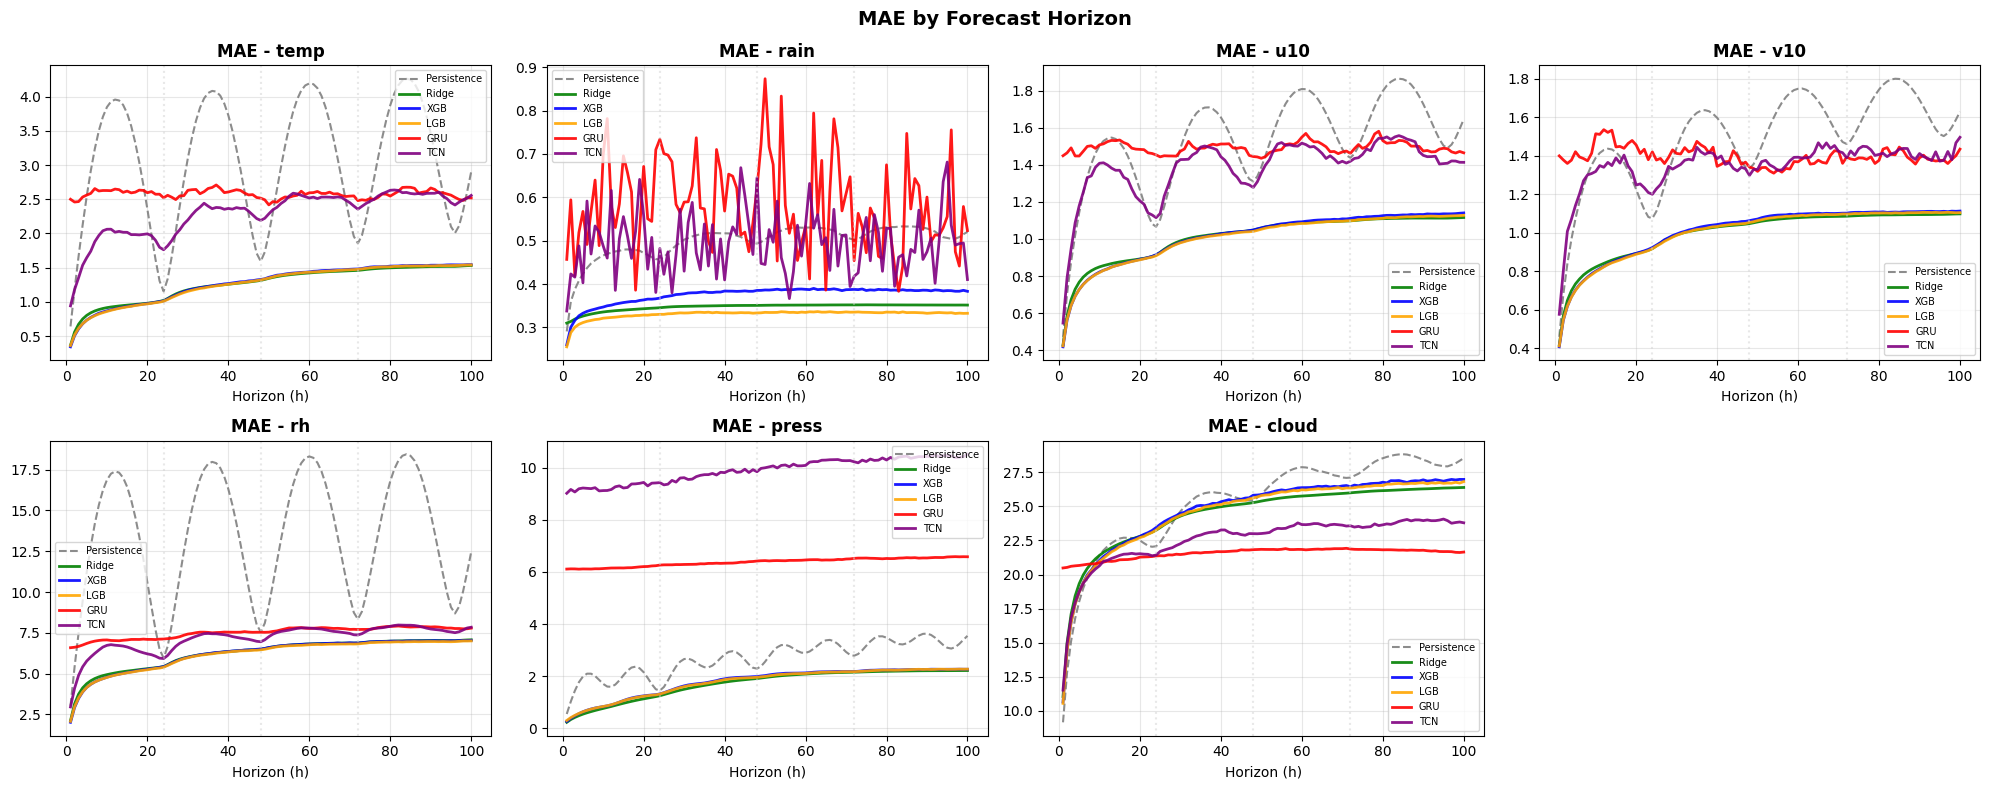


[2] MAE Heatmaps


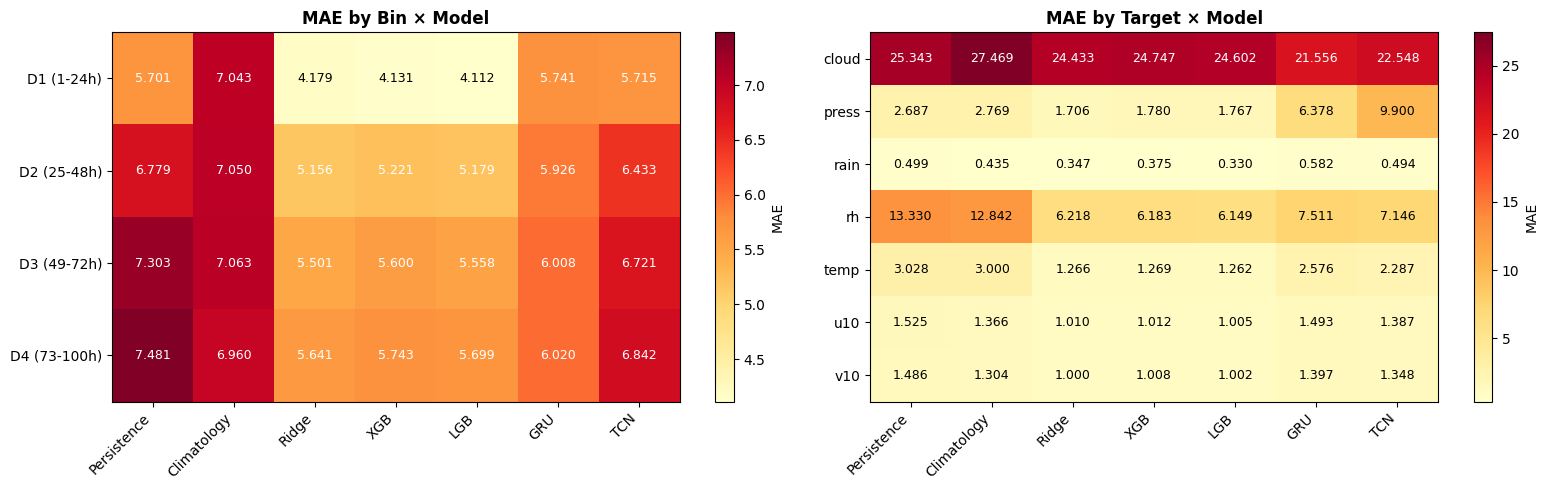


[3] Skill Score Bar Chart


C:\Users\tuanh\AppData\Local\Temp\ipykernel_16868\3124847622.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


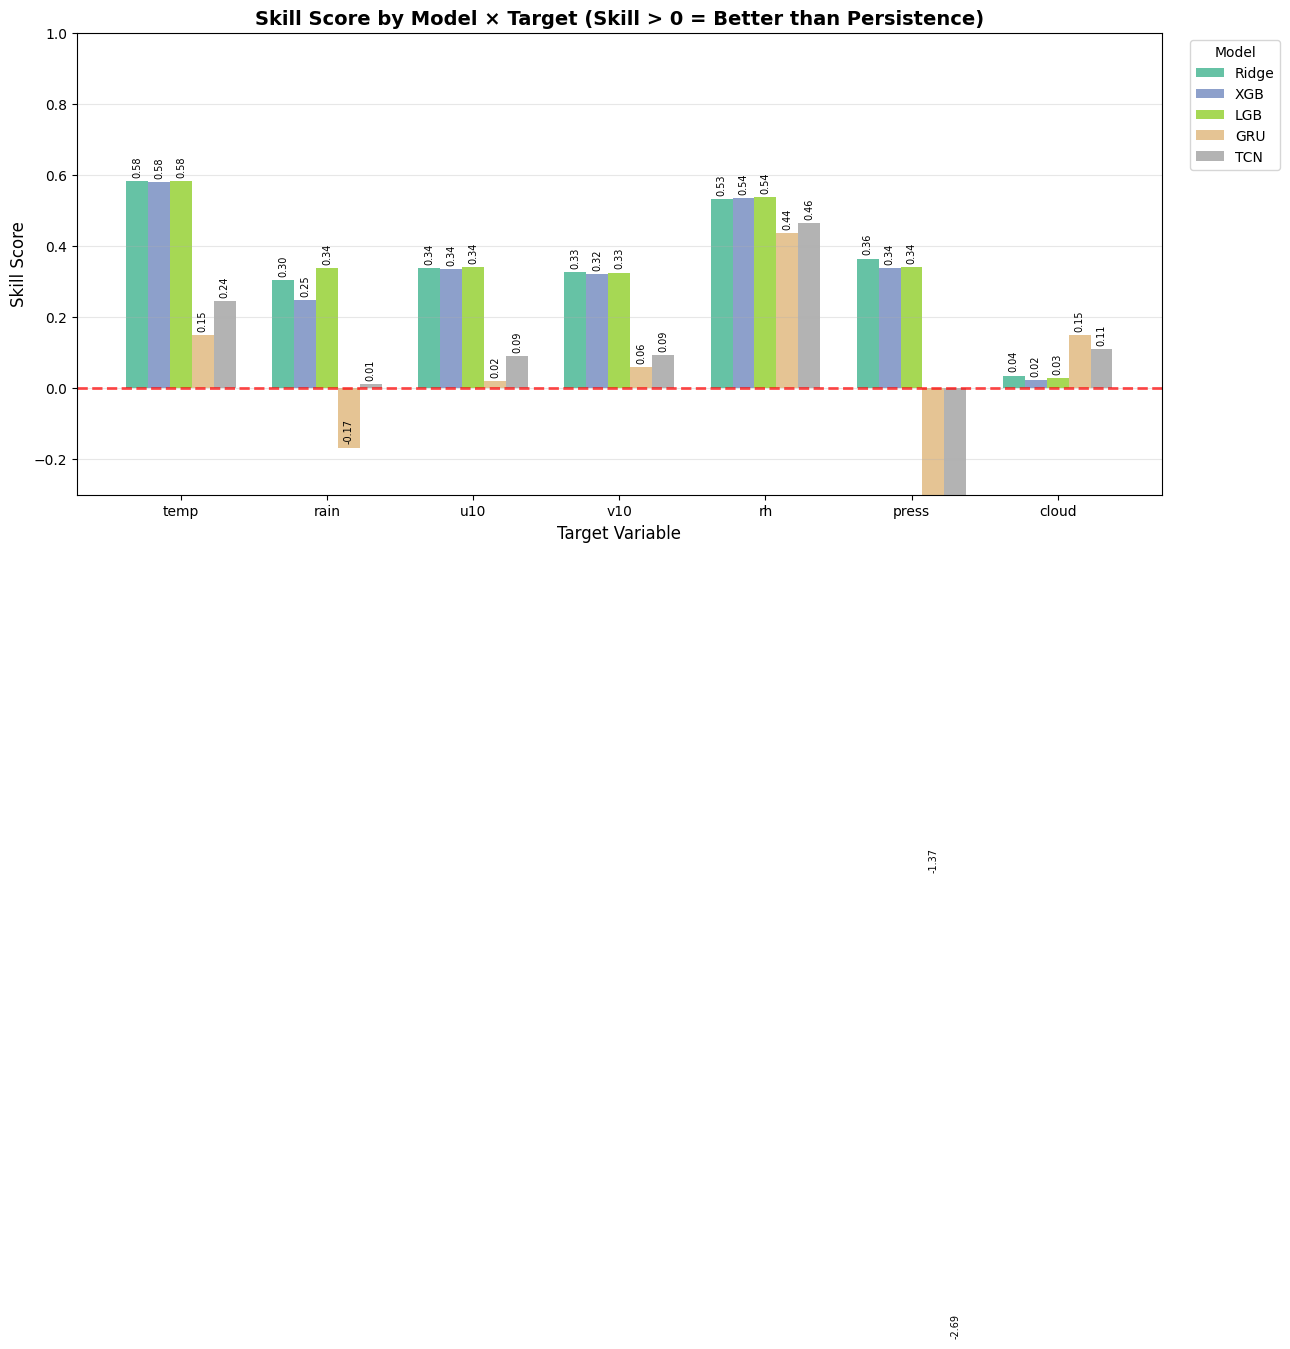


[4] MAE by Bin (per target)


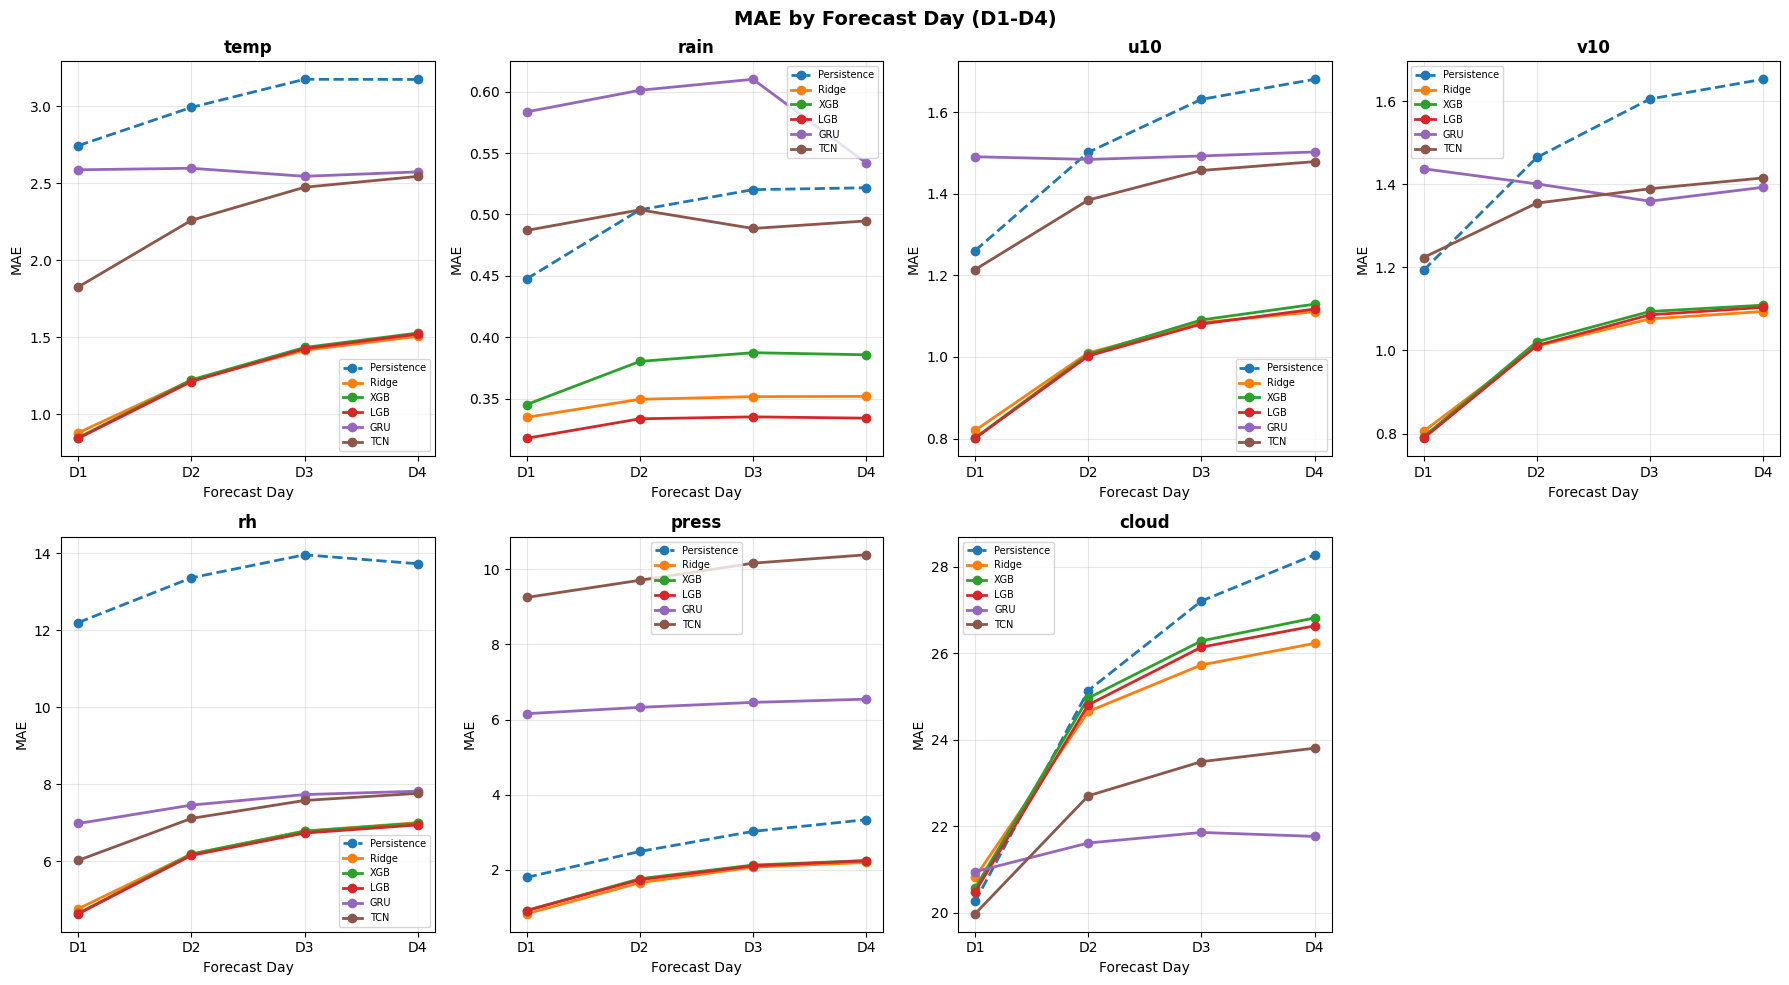


✅ Cell 7 Done


In [9]:
# ============================================================
# CELL 7: VISUALIZATIONS
# ============================================================
print("="*60)
print("📊 VISUALIZATIONS")
print("="*60)

COLORS = {"Persistence": "gray", "Climatology": "brown",
          "Ridge": "green", "XGB": "blue", "LGB": "orange",
          "GRU": "red", "TCN": "purple"}

# ==================== 1. MAE by Horizon ====================
print("\n[1] MAE by Horizon (line plot)")

n_cols, n_rows = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, target in enumerate(TARGETS):
    ax = axes[i]
    df_t = df_all[df_all["target"] == target]
    
    for fam in ["Persistence", "Ridge", "XGB", "LGB", "GRU", "TCN"]:
        g = df_t[df_t["family"] == fam]
        if len(g) == 0: continue
        g_agg = g.groupby("h")["mae"].mean()
        ls = "--" if fam == "Persistence" else "-"
        lw = 1.5 if fam == "Persistence" else 2
        ax.plot(g_agg.index, g_agg.values, label=fam, linestyle=ls, 
                linewidth=lw, color=COLORS.get(fam), alpha=0.9)
    
    for h_end in [24, 48, 72]:
        ax.axvline(x=h_end, color="lightgray", linestyle=":", alpha=0.5)
    
    ax.set_title(f"MAE - {target}", fontweight="bold")
    ax.set_xlabel("Horizon (h)")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

for j in range(len(TARGETS), len(axes)):
    axes[j].axis("off")

plt.suptitle("MAE by Forecast Horizon", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "mae_by_horizon.png", dpi=150)
plt.show()

# ==================== 2. Heatmaps ====================
print("\n[2] MAE Heatmaps")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bin × Family
ax = axes[0]
hm = pivot_bin.values
im = ax.imshow(hm, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(len(pivot_bin.columns)))
ax.set_yticks(range(len(pivot_bin.index)))
ax.set_xticklabels(pivot_bin.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot_bin.index)
for i in range(len(pivot_bin.index)):
    for j in range(len(pivot_bin.columns)):
        v = hm[i, j]
        if not np.isnan(v):
            c = "white" if v > np.nanmax(hm) * 0.6 else "black"
            ax.text(j, i, f"{v:.3f}", ha="center", va="center", color=c, fontsize=9)
ax.set_title("MAE by Bin × Model", fontweight="bold")
plt.colorbar(im, ax=ax, label="MAE")

# Target × Family
ax = axes[1]
hm = pivot_mae.values
im = ax.imshow(hm, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(len(pivot_mae.columns)))
ax.set_yticks(range(len(pivot_mae.index)))
ax.set_xticklabels(pivot_mae.columns, rotation=45, ha="right")
ax.set_yticklabels(pivot_mae.index)
for i in range(len(pivot_mae.index)):
    for j in range(len(pivot_mae.columns)):
        v = hm[i, j]
        if not np.isnan(v):
            c = "white" if v > np.nanmax(hm) * 0.6 else "black"
            ax.text(j, i, f"{v:.3f}", ha="center", va="center", color=c, fontsize=9)
ax.set_title("MAE by Target × Model", fontweight="bold")
plt.colorbar(im, ax=ax, label="MAE")

plt.tight_layout()
plt.savefig(OUT_DIR / "mae_heatmaps.png", dpi=150)
plt.show()

# ==================== 3. Skill Score Bar Chart ====================
print("\n[3] Skill Score Bar Chart")

if len(skill_pivot) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(TARGETS))
    width = 0.15
    models = [m for m in FAMILIES if m in skill_pivot.columns]
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        vals = [skill_pivot.loc[t, model] if t in skill_pivot.index else 0 for t in TARGETS]
        bars = ax.bar(x + i * width, vals, width, label=model, color=colors[i])
        for bar, v in zip(bars, vals):
            if not np.isnan(v):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f"{v:.2f}", ha="center", va="bottom", fontsize=7, rotation=90)
    
    ax.axhline(y=0, color="red", linestyle="--", linewidth=2, alpha=0.7)
    ax.set_xlabel("Target Variable", fontsize=12)
    ax.set_ylabel("Skill Score", fontsize=12)
    ax.set_title("Skill Score by Model × Target (Skill > 0 = Better than Persistence)", 
                 fontsize=14, fontweight="bold")
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(TARGETS, fontsize=10)
    ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(True, alpha=0.3, axis="y")
    ax.set_ylim(-0.3, 1.0)
    plt.tight_layout()
    plt.savefig(OUT_DIR / "skill_bar_chart.png", dpi=150)
    plt.show()

# ==================== 4. MAE by Bin Line Plot ====================
print("\n[4] MAE by Bin (per target)")

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, target in enumerate(TARGETS):
    ax = axes[i]
    df_t = df_all[df_all["target"] == target]
    
    for fam in ["Persistence", "Ridge", "XGB", "LGB", "GRU", "TCN"]:
        df_tf = df_t[df_t["family"] == fam]
        if len(df_tf) == 0: continue
        mae_by_bin = df_tf.groupby("bin")["mae"].mean().reindex(BIN_NAMES)
        ls = "--" if fam == "Persistence" else "-"
        ax.plot(range(4), mae_by_bin.values, marker="o", label=fam, linewidth=2, linestyle=ls)
    
    ax.set_xticks(range(4))
    ax.set_xticklabels(["D1", "D2", "D3", "D4"])
    ax.set_title(f"{target}", fontweight="bold")
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Forecast Day")
    ax.set_ylabel("MAE")

for j in range(len(TARGETS), len(axes)):
    axes[j].axis("off")

plt.suptitle("MAE by Forecast Day (D1-D4)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "mae_by_bin_lineplot.png", dpi=150)
plt.show()

print(f"\n✅ Cell 7 Done")

In [10]:
# ============================================================
# CELL 8: QUALITY CHECK
# ============================================================
print("="*60)
print("🔍 QUALITY CHECK")
print("="*60)

ALL_FAMILIES = BASELINES + FAMILIES

# ==================== 1. COVERAGE ====================
print("\n[1] COVERAGE ANALYSIS")

expected = pd.DataFrame(
    list(product(ALL_FAMILIES, [LOC_MAP.get(lid, lid[:8]) for lid in LOCATION_IDS],
                 TARGETS, range(H_START, H_END + 1))),
    columns=["family", "loc", "target", "h"]
)
actual = df_all[["family", "loc", "target", "h"]].drop_duplicates()
missing = expected.merge(actual.assign(_=1), how="left").query("_.isna()").drop(columns=["_"])

print(f"\n📊 Expected: {len(expected):,} | Actual: {len(actual):,} | Missing: {len(missing):,}")
print(f"   Coverage: {100*len(actual)/len(expected):.1f}%")

# By Family
print("\n📋 Coverage by Family:")
cov_fam = []
for fam in ALL_FAMILIES:
    exp = len(LOCATION_IDS) * len(TARGETS) * (H_END - H_START + 1)
    act = len(df_all[df_all["family"] == fam])
    cov_fam.append({"family": fam, "expected": exp, "actual": act,
                    "coverage_%": round(100*act/exp, 1) if exp > 0 else 0})
df_cov_fam = pd.DataFrame(cov_fam)
display(df_cov_fam)

# ==================== 2. HORIZON CONSISTENCY ====================
print("\n[2] HORIZON CONSISTENCY (MAE should increase with h)")

anomalies = []
for (fam, tgt), g in df_all.groupby(["family", "target"]):
    agg = g.groupby("h")["mae"].mean()
    if len(agg) < 10: continue
    h_arr, m_arr = agg.index.values, agg.values
    corr = np.corrcoef(h_arr, m_arr)[0, 1]
    mae_d1 = agg[agg.index <= 24].mean()
    mae_d4 = agg[agg.index >= 73].mean()
    change = ((mae_d4 - mae_d1) / mae_d1 * 100) if mae_d1 > 0 else 0
    is_bad = corr < -0.5
    anomalies.append({
        "family": fam, "target": tgt,
        "corr(h,mae)": round(corr, 3),
        "mae_D1": round(mae_d1, 4), "mae_D4": round(mae_d4, 4),
        "change_%": round(change, 1),
        "status": "❌ MISMATCH" if is_bad else "✓ OK"
    })

df_anom = pd.DataFrame(anomalies).sort_values("corr(h,mae)")
display(df_anom)

bad = df_anom[df_anom["status"] == "❌ MISMATCH"]
if len(bad) > 0:
    print(f"\n🚨 {len(bad)} HORIZON MISMATCH ISSUES:")
    for _, r in bad.iterrows():
        print(f"   {r['family']} × {r['target']}: corr={r['corr(h,mae)']}")
else:
    print("\n✅ All models show expected MAE increase with horizon")

# ==================== 3. SCALE OUTLIERS ====================
print("\n[3] SCALE OUTLIER CHECK")

scale = []
for t in TARGETS:
    df_t = df_all[df_all["target"] == t]
    fam_mae = df_t.groupby("family")["mae"].mean()
    med = fam_mae.median()
    for f, v in fam_mae.items():
        ratio = v / med if med > 0 else 0
        scale.append({
            "target": t, "family": f, "mae": round(v, 4),
            "ratio_to_median": round(ratio, 2),
            "status": "⚠️ OUTLIER" if ratio > 3 or ratio < 0.33 else "✓ OK"
        })

df_scale = pd.DataFrame(scale)
outliers = df_scale[df_scale["status"] == "⚠️ OUTLIER"]
if len(outliers) > 0:
    print("⚠️ Scale outliers:")
    display(outliers)
else:
    print("✅ No scale outliers")

# ==================== SAVE REPORTS ====================
df_cov_fam.to_csv(OUT_DIR / "coverage_by_family.csv", index=False)
df_anom.to_csv(OUT_DIR / "horizon_consistency.csv", index=False)
df_scale.to_csv(OUT_DIR / "scale_check.csv", index=False)

# ==================== OUTPUT FILES ====================
print("\n" + "="*60)
print("📁 OUTPUT FILES:")
for f in sorted(OUT_DIR.glob("*.csv")):
    print(f"  - {f.name}")
for f in sorted(OUT_DIR.glob("*.png")):
    print(f"  - {f.name}")

# Quality Score
n_critical = len(bad)
cov_pct = 100 * len(actual) / len(expected)
print("\n" + "="*60)
if n_critical > 0:
    print(f"❌ QUALITY: ISSUES ({n_critical} horizon mismatches)")
elif cov_pct >= 80:
    print(f"✅ QUALITY: GOOD (coverage {cov_pct:.1f}%)")
else:
    print(f"⚠️ QUALITY: LOW COVERAGE ({cov_pct:.1f}%)")
print("="*60)

print("\n✅ Cell 8 Done - Verification Complete!")

🔍 QUALITY CHECK

[1] COVERAGE ANALYSIS

📊 Expected: 98,000 | Actual: 98,000 | Missing: 0
   Coverage: 100.0%

📋 Coverage by Family:


,family,expected,actual,coverage_%
0,Persistence,14000,14000,100.0
1,Climatology,14000,14000,100.0
2,Ridge,14000,14000,100.0
3,XGB,14000,14000,100.0
4,LGB,14000,14000,100.0
5,GRU,14000,14000,100.0
6,TCN,14000,14000,100.0



[2] HORIZON CONSISTENCY (MAE should increase with h)


,family,target,"corr(h,mae)",mae_D1,mae_D4,change_%,status
13,GRU,v10,-0.346,1.4372,1.3926,-3.1,✓ OK
9,GRU,rain,-0.146,0.5835,0.5419,-7.1,✓ OK
2,Climatology,rain,-0.129,0.4362,0.4328,-0.8,✓ OK
11,GRU,temp,-0.109,2.5878,2.5745,-0.5,✓ OK
6,Climatology,v10,-0.091,1.3060,1.2893,-1.3,✓ OK
3,Climatology,rh,-0.090,12.9429,12.4857,-3.5,✓ OK
4,Climatology,temp,-0.085,3.0214,2.9195,-3.4,✓ OK
5,Climatology,u10,-0.084,1.3684,1.3527,-1.1,✓ OK
0,Climatology,cloud,-0.083,27.4765,27.4657,-0.0,✓ OK
1,Climatology,press,-0.001,2.7482,2.7735,0.9,✓ OK



✅ All models show expected MAE increase with horizon

[3] SCALE OUTLIER CHECK
⚠️ Scale outliers:


,target,family,mae,ratio_to_median,status
40,press,TCN,9.9002,3.69,⚠️ OUTLIER



📁 OUTPUT FILES:
  - all_metrics_combined.csv
  - best_model_per_target.csv
  - coverage_by_family.csv
  - horizon_consistency.csv
  - mae_by_bin_family.csv
  - mae_by_target_family.csv
  - mae_degradation.csv
  - mae_rmse_degradation.csv
  - rain_event_metrics.csv
  - rmse_by_bin_family.csv
  - rmse_by_target_family.csv
  - scale_check.csv
  - skill_pivot.csv
  - skill_pivot_mae.csv
  - skill_pivot_rmse.csv
  - skill_scores.csv
  - mae_by_bin_lineplot.png
  - mae_by_horizon.png
  - mae_heatmaps.png
  - skill_bar_chart.png

✅ QUALITY: GOOD (coverage 100.0%)

✅ Cell 8 Done - Verification Complete!
